In [1]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath

from datetime import datetime, date

from sktensor import dtensor, cp_als
matplotlib.style.use('ggplot')

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als

from numpy import linalg as LA

matplotlib.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Downloading and preprocessing the dataset
# The variable "tab" has integers datetime
execfile('Library/Initialization_rado-square_matrix.py')
T.shape

(167, 167, 238)

## Dataset Temporal Split
We use (sender,receiver)_t matrix for t between t_0 and t_1. This temporal window shifts as t_0 incresases.  
t_0 is s.t. t_0+t_1 <= T.shape[2] = 238
  
Since we would like to move this window around 3 weeks, we choose t_0 <= 21 and a constant window size of length 238-21=217

In [3]:
t_0 = 0
t_1 = t_0 + 30

if t_1 <= T.shape[2]:
    T_train = T[:, :, t_0:t_1]
    T_test = T[:, :, t_1:]
    print('Initial time: t_0 = %d [%s]\nFinal time:   t_1 = %d [%s]') %(t_0,
                                                                                  k_list[t_0],
                                                                                  t_1,
                                                                                  k_list[t_1])
else:
    print('t_0=%d is superior to the maximal value 21!') %(t_0)

Initial time: t_0 = 0 [733774]
Final time:   t_1 = 30 [733808]


In [4]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T) / float(T.shape[0] * T.shape[1] * T.shape[2])

In [5]:
mail_rate

0.008442532235383307

# CanDecom/ParaFac (CP) Decomposition

In [15]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

### Collapsed Unweighted Tensor  
Precision-Recall for several values of K

In [17]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [7,15, 21]
tau_list = [7]
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

precision = dict()
recall = dict()
average_precision = dict()

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # CP Decomposition
        P, fit, itr, exectimes = cp_als(T_train, K, init='random')
        A, B, C = P.U
        # CP Scoring
        gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
        Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
        for i in range(Sk.shape[0]) :
            for j in range(Sk.shape[1]) :
                Sk[i,j] = float(Sk[i,j])
        S += Sk/LA.norm(Sk, 'fro')

    y_score = S.flatten()
    y_test = S_test.flatten()
    
    # Precision-Recall
    #precision[tau], recall[tau], _ = precision_recall_curve(y_test, y_score)
    #average_precision[tau] = average_precision_score(y_test, y_score)    
    # ROC 
    FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for tau_ind in range(len(tau_list)): 
    plt.plot(FPR[tau_ind], TPR[tau_ind], label='CP - AUC={0:0.2f}' .format(AUC[tau_ind]), linewidth = 2.0)

plt.axhline(mail_rate, label='random', color='black', linewidth=2.0)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.xlabel('False Positive Rate', fontsize=16)
#plt.ylabel('True Positive Rate', fontsize=16)
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.legend(loc="upper right", fontsize=14)
#plt.title('Radoslaw days scale \nROC for CP Factorization of rank K \nCollapsed Unweighted Tensor', fontsize=20)
#plt.savefig('Radoslaw days cp_roc_cut.pdf')    

KeyboardInterrupt: 

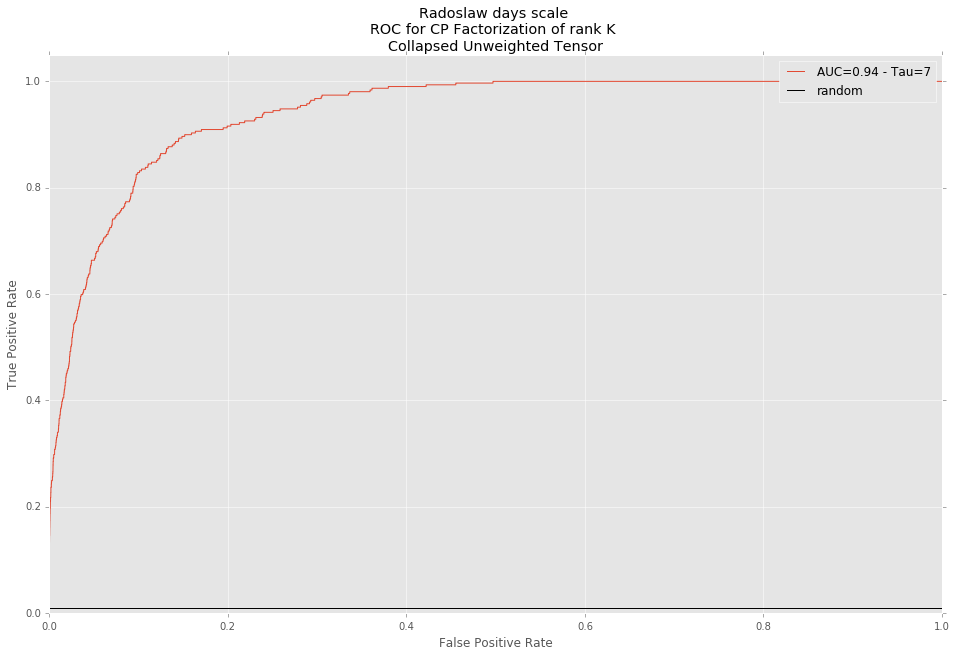

In [17]:
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for tau_ind in range(len(tau_list)): 
    plt.plot(FPR[tau_ind], TPR[tau_ind], label='AUC={0:0.2f} - Tau=%d' .format(AUC[tau_ind]) %(tau_list[tau_ind]))

plt.axhline(mail_rate, label='random', color='black')
#plt.xlabel('Recall')
#plt.ylabel('Precision')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw days scale \nROC for CP Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('Radoslaw days cp_roc_cut.pdf')    

### Exponential Smoothing  
Precision-Recall for several values of K

In [ ]:
K_list = [1, 5, 10, 30, 50, 100]
tau_list = [7]
#, 15, 21]
alpha_list = [0.2]
#, 0.5, 0.8]

for alpha_ind in range(len(alpha_list)):
    # Initialization
    FPR = dict()
    TPR = dict()
    AUC = dict()
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

        y_score = S.flatten()
        y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

        # ROC 
        FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)

    # Plotting the results
    #plt.clf()
    #plt.figure(figsize=(16, 10))

    for tau_ind in range(len(tau_list)): 
        plt.plot(FPR[tau_ind], TPR[tau_ind], label='Exponential Smoothing - AUC={0:0.2f}' .format(AUC[tau_ind]))

    #plt.axhline(mail_rate, label='random', color='black')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.legend(loc="upper right")
    #plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \
    #              \nCollapsed Weighted Tensor -  Alpha = %.2f - Exponential Smoothing' %(alpha))
    #plt.savefig('Radoslaw day cp_roc_cwt_%.2f Exponential Smoothing.pdf' %(alpha))   
    

## Scoring Analysis

### Maximum Analysis

In [44]:
# Which pair of (sender, receiver) has a maximal score? 
i_ind, j_ind = np.unravel_index(S.argmax(), S.shape)
i, j = i_list[i_ind], j_list[j_ind]
print('Predicted Score for sender %d to receiver %d for time %d: %f mails'%(i,
                                                                            j,
                                                                            k_list[t_1],
                                                                            S[i_ind, j_ind]))

Predicted Score for sender 13 to receiver 3 for time 733808: 3.012485 mails


In [49]:
X_max = X.ix[(X.sender == i)&(X.receiver == j)&(X.datetime <= k_list[t_1])]

nb_train = len(X_max.ix[X.datetime < k_list[t_1]])
nb_train_tau = len(X_max.ix[(X.datetime < k_list[t_1])&(X.datetime >= k_list[t_1-tau])])
nb_test = len(X_max.ix[X.datetime == k_list[t_1]])

print('%0.2f mails sent during the trainset with %0.2f during the tau-selected window. \n%d mails actually sent at time %d' \
      %(nb_train,
        nb_train_tau,
        nb_test,
        k_list[t_1]))

96.00 mails sent during the trainset with 67.00 during the tau-selected window. 
6 mails actually sent at time 733808


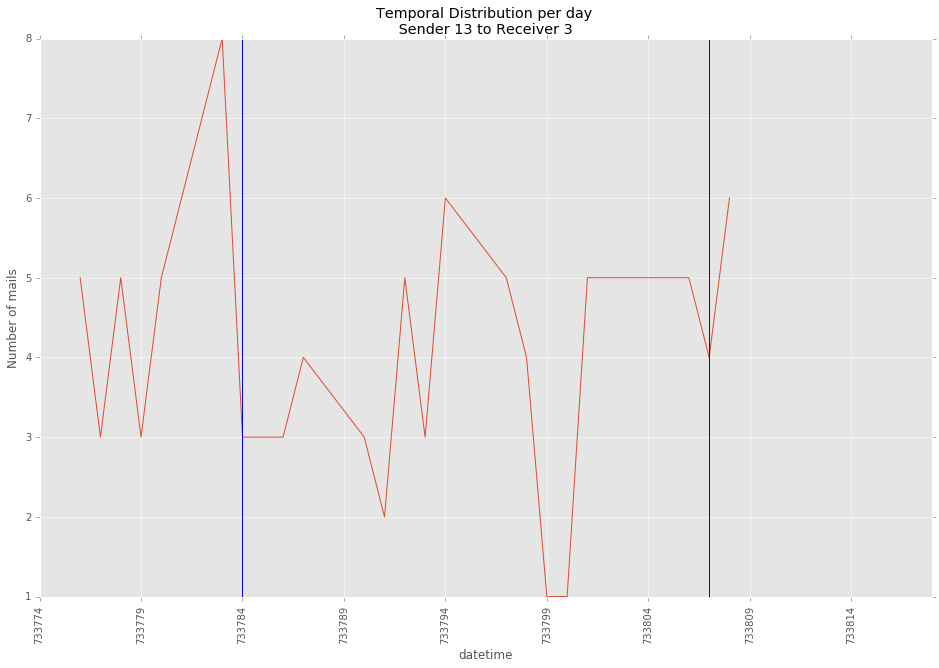

In [50]:
X_max_count = X_max.datetime.groupby(X_max.datetime).count()

plt.figure(figsize=(16, 10))
plt.title('Temporal Distribution per day \n Sender %d to Receiver %d ' %(i, j))
plt.ylabel('Number of mails')
plt.xlabel('datetime')
plt.xlim([k_list[t_0], k_list[t_1]+10])
plt.grid('on')
plt.plot(X_max_count.index, X_max_count)
plt.xticks(np.arange(k_list[t_0], k_list[t_1]+10, 5), rotation=90)
plt.ticklabel_format(useOffset=False)

plt.axvline(k_list[t_1-tau])
plt.axvline(k_list[t_1-1])

### Factorization Analysis

In [65]:
for i in range(T_train.shape[2]):
    print i, T[:,50,i].argmax(), np.exp(T[T[:,50,i].argmax(),50,i] - 1)

0 0 0.367879441171
1 2 1.0
2 2 2.0
3 2 3.0
4 2 2.0
5 7 2.0
6 0 0.367879441171
7 0 0.367879441171
8 2 1.0
9 2 2.0
10 23 1.0
11 23 2.0
12 0 0.367879441171
13 0 0.367879441171
14 2 2.0
15 2 3.0
16 2 1.0
17 2 1.0
18 0 0.367879441171
19 2 3.0
20 2 3.0
21 0 0.367879441171
22 6 1.0
23 2 4.0
24 0 0.367879441171
25 0 0.367879441171
26 2 5.0
27 49 2.0
28 2 2.0
29 2 2.0


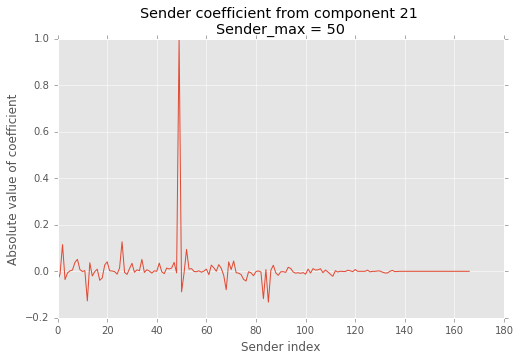

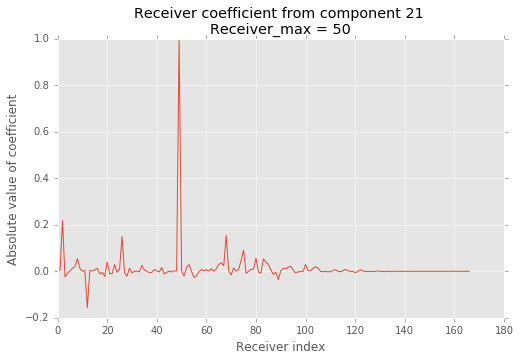

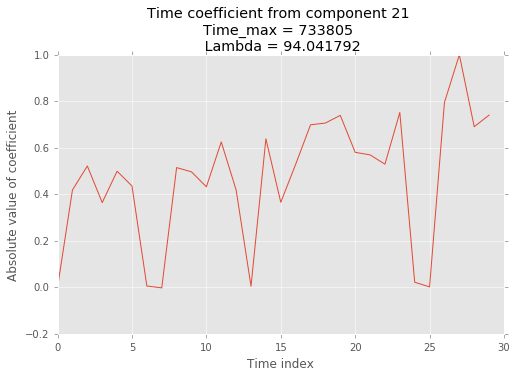

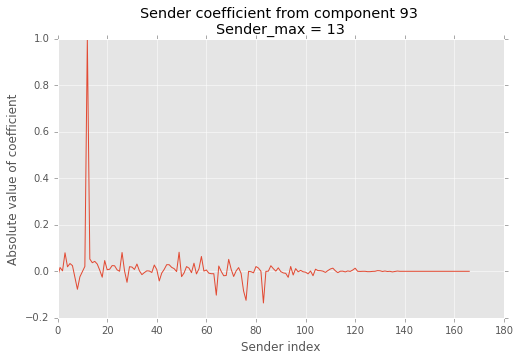

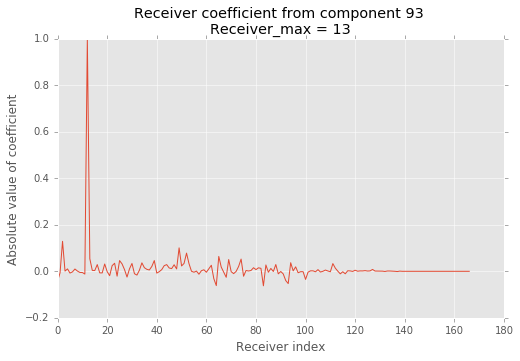

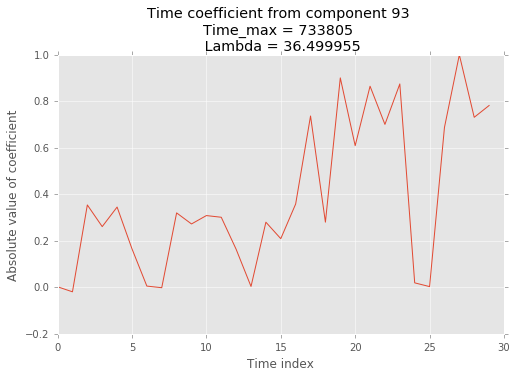

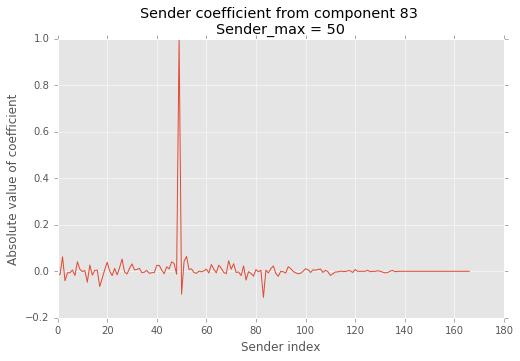

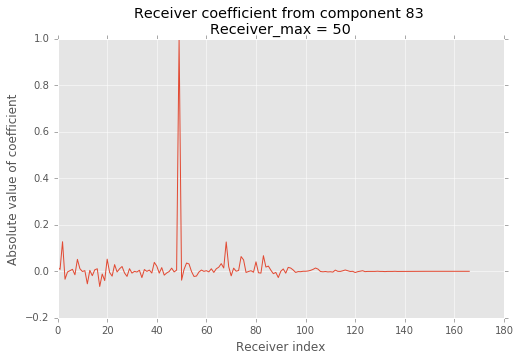

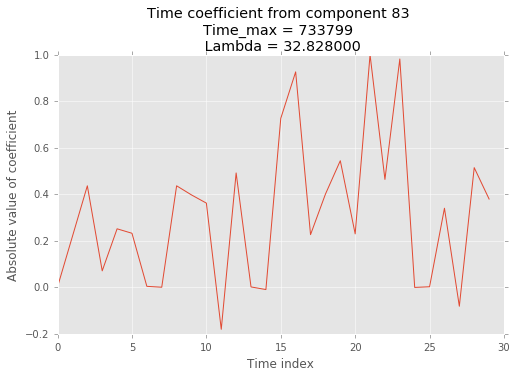

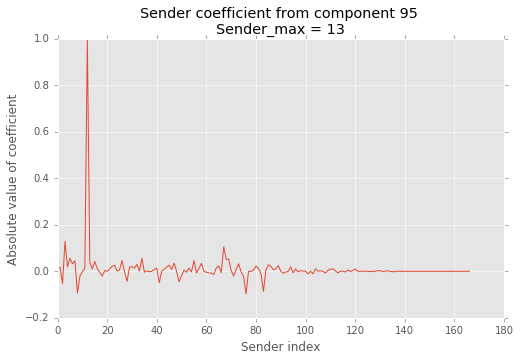

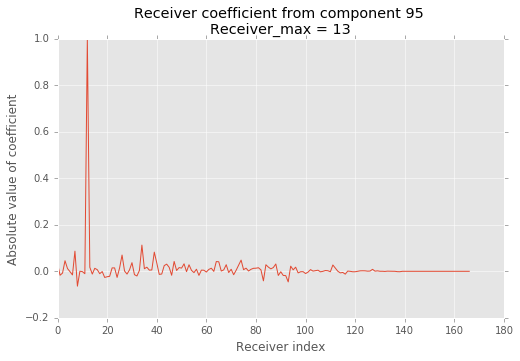

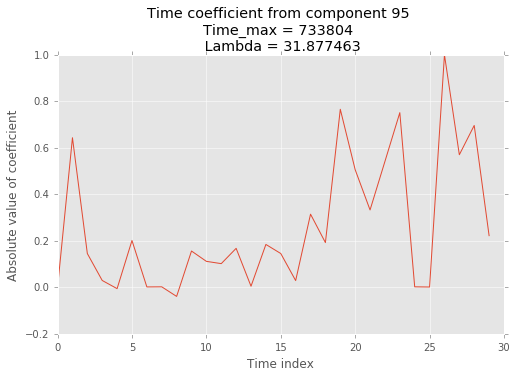

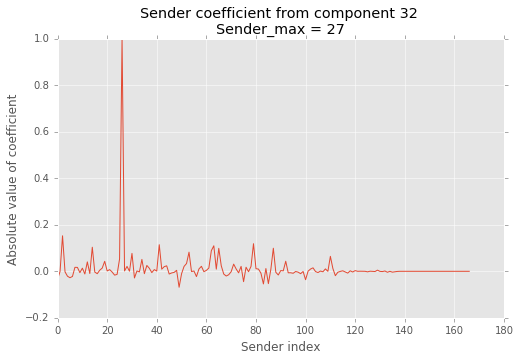

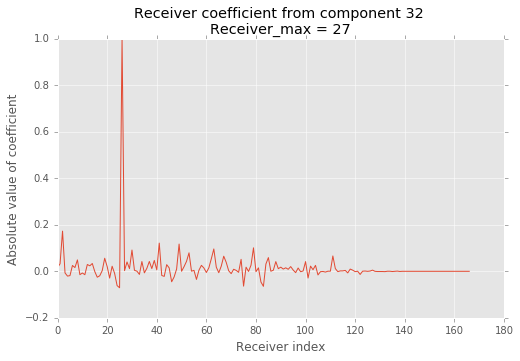

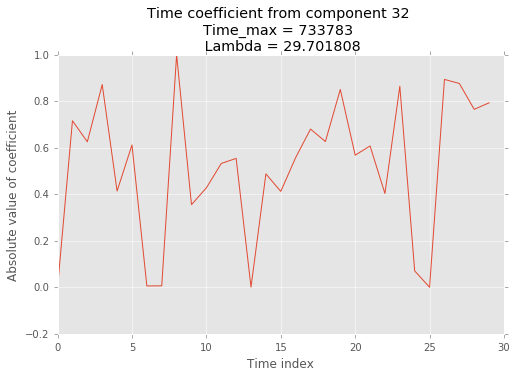

In [55]:
for k in (-P.lmbda).argsort()[:5]:
    i_ind = abs(A[:, k]).argmax()
    i_max = i_list[i_ind]

    j_ind = abs(B[:, k]).argmax()
    j_max = j_list[j_ind]

    k_ind = abs(C[:, k]).argmax()
    k_max = k_list[k_ind]

    plt.figure(figsize=(8, 5))
    plt.title('Sender coefficient from component %d \nSender_max = %d' %((k+1), i_max))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Sender index')
    plt.plot(A[:, k])
    plt.savefig('Radoslaw day cp_sender_analysis_component_%d.pdf' %(k+1))    

    plt.figure(figsize=(8, 5))
    plt.title('Receiver coefficient from component %d \nReceiver_max = %d' %((k+1), j_max))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Receiver index')
    plt.plot(B[:, k])
    plt.savefig('Radoslaw day cp_receiver_analysis_component_%d.pdf' %(k+1))    
    
    plt.figure(figsize=(8, 5))
    plt.title('Time coefficient from component %d \nTime_max = %d \n Lambda = %f' %((k+1), k_max, P.lmbda[k]))
    plt.ylabel('Absolute value of coefficient')
    plt.xlabel('Time index')
    plt.plot(C[:, k])
    plt.savefig('Radoslaw day cp_time_analysis_component_%d.pdf' %(k+1))     

# TSVD, Katz, TKatz

## Collapsed unweighted tensor

In [18]:
CUT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))

for k in range(T.shape[2]):
    CUT = CUT + T[:,:,k]

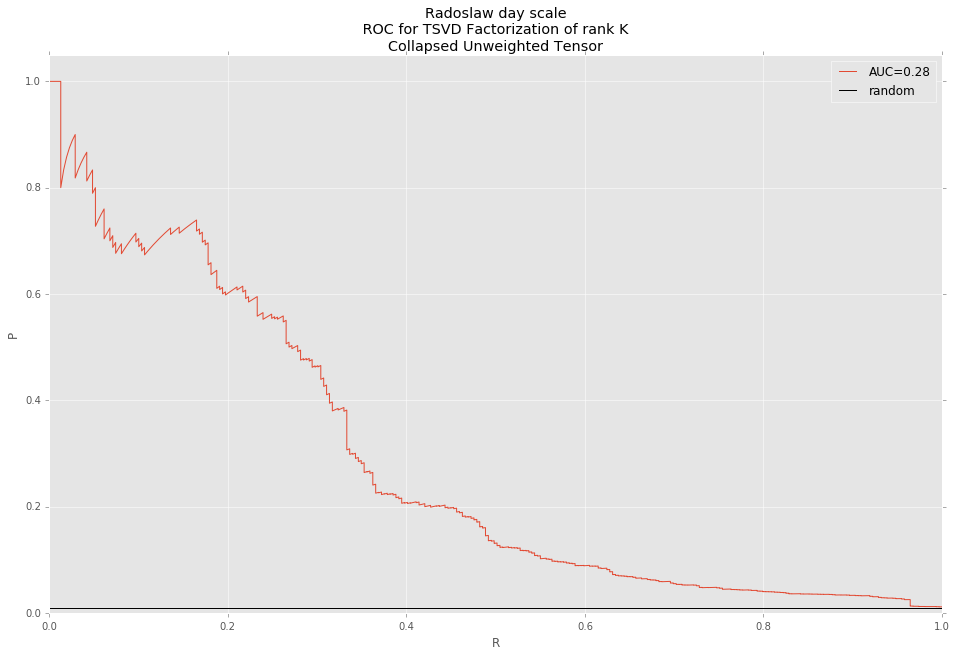

In [13]:
S = np.zeros((CWT.shape[0], CWT.shape[1]))
S_pred = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test_all = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

K_list = [1,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        
        # Precision-Recall
        #precision, recall, _ = precision_recall_curve(y_test,y_score)
        #average_precision = average_precision_score(y_test, y_score)    

        # ROC 
        FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        plt.plot(FPR[i], TPR[i], label='Predicting all links - AUC={0:0.2f}' .format(AUC[i]))
        #plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))
    #else :
    #    plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('R')
plt.ylabel('P')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TSVD Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('Radoslaw day TSVD_roc_cut.pdf')   

### Katz  
Precision-Recall for several values of Beta

i=0
i=1


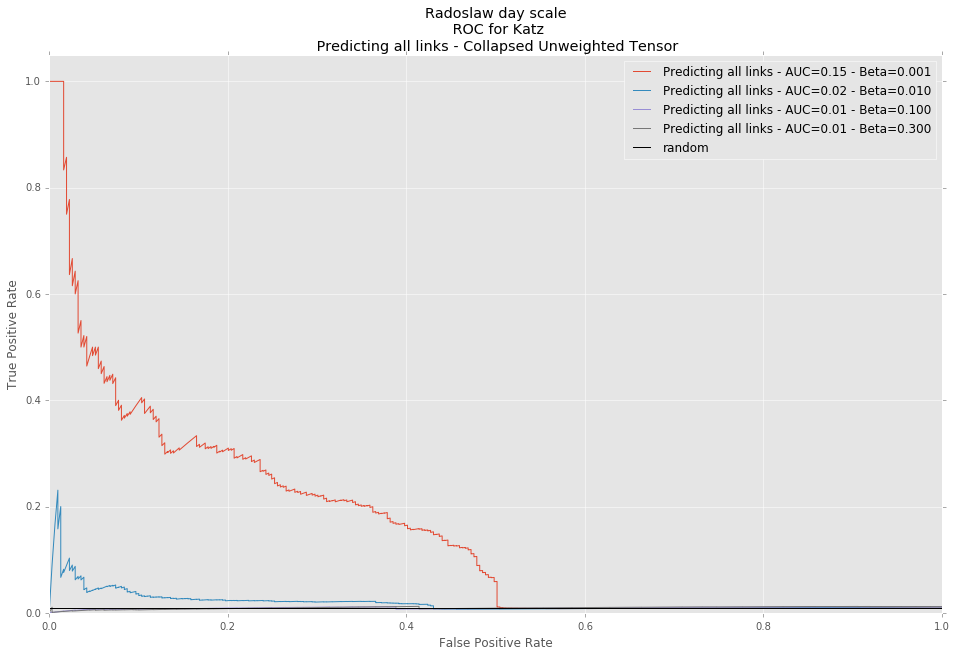

In [11]:
K_list = [1,5,10,30,50]
beta_list= [0.001]
#, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CUT.shape[0], CUT.shape[1]))

# Initialization
precision = dict()
recall = dict()
average_precision = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        S = np.linalg.inv(np.eye(CUT.shape[0]) - beta*CUT) - np.eye(CUT.shape[0])
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        #precision[count], recall[count], _ = precision_recall_curve(y_test,y_score)
        #average_precision[count] = average_precision_score(y_test, y_score)
        
        count += 1

# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(average_precision[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for Katz\n Predicting all links - Collapsed Unweighted Tensor')
plt.savefig('Radoslaw day Predicting all links Katz_roc_cut.pdf')  



In [2]:
K_list = [1,5,10,30,50]
beta_list= [0.001, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CUT.shape[0], CUT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            D, W = np.linalg.eig(np.dot(U,np.dot(np.diag(Sigma), Vt)))
            gamma = []
            for j in range(len(D)) :
                gamma += [1/(1-beta*D[j]) - 1]
            Sk = np.dot(W,np.dot(np.diag(gamma), W.transpose()))
            Sk_real = np.zeros((Sk.shape[0], Sk.shape[1]))
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk_real[i,j] = Sk[i,j].real
            S += Sk_real/LA.norm(Sk_real, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
        count += 1

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TKatz\n Predicting all links - Collapsed Unweighted Tensor')
plt.savefig('Radoslaw day Predicting all links TKatz_roc_cut.pdf')  

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label= 'Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
count += 1

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TKatz\n Predicting new links - Collapsed Unweighted Tensor')
plt.savefig('Radoslaw day Predicting new links TKatz_roc_cut.pdf')  

NameError: name 'np' is not defined

## Collapsed weighted tensor

In [19]:
CWT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))
theta = 0.2
K = len(k_list)

for k in range(K):
    CWT = CWT + (1-theta)**(K - k)*T[:,:,k]

In [7]:
CWT

dtensor([[ 0.        ,  0.69987861,  0.79923661, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69598695,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79389821,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### TSVD  
Precision-Recall for several values of K

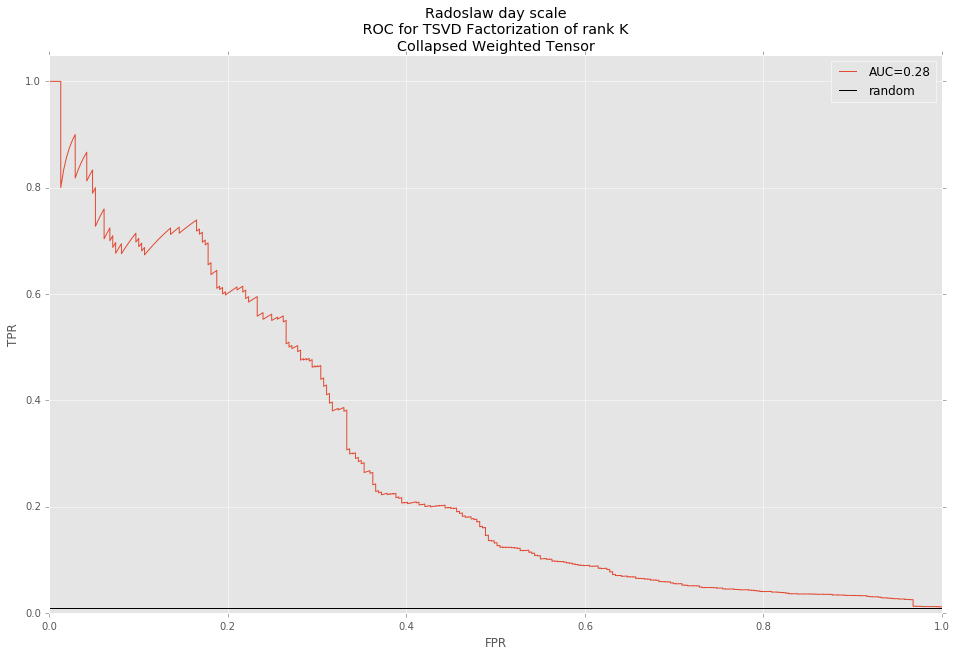

In [8]:
S = np.zeros((CWT.shape[0], CWT.shape[1]))

theta = 0.2
K_list = [1,5,10,30,50]
FPR = dict()
TPR = dict()
AUC = dict()

precision = {}
recall = {}
average_precision = {}

S_test = (1*np.array(T_test[:, :, 0] >= 1))

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        # ROC 
        FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
        #precision[i], recall[i], _ = precision_recall_curve(y_test, y_score)
        #average_precision[i] = average_precision_score(y_test, y_score) 
       
    
# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        plt.plot(FPR[i], TPR[i], label='Predicting all links - AUC={0:0.2f}' .format(AUC[i]))
        #plt.plot(recall[i], precision[i], label='AUC={0:0.2f}' .format(average_precision[i]))
    #else :
     #   plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TSVD Factorization of rank K \nCollapsed Weighted Tensor')
plt.savefig('Radoslaw day TSVD_roc_cwt.pdf')      

### Katz  
Precision-Recall for several values of Beta

In [1]:
K_list = [1,5,10,30,50]
beta_list= [0.001, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CWT.shape[0], CWT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            D, W = np.linalg.eig(np.dot(U,np.dot(np.diag(Sigma), Vt)))
            gamma = []
            for j in range(len(D)) :
                gamma += [1/(1-beta*D[j]) - 1]
            Sk = np.dot(W,np.dot(np.diag(gamma), W.transpose()))
            S_ = np.zeros((Sk.shape[0], Sk.shape[1]))
            nz = Sk.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S_[i_ind, j_ind] = Sk[i_ind, j_ind].real
            S += S_/LA.norm(Sk, 'fro')    
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        precision[count], recall[count], _ = precision_recall_curve(y_test,y_score)
        average_precision[count] = average_precision_score(y_test, y_score)
        
        count += 1

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(recall[count], precision[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(average_precision[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TKatz\n Predicting all links - Collapsed Weighted Tensor')
plt.savefig('Radoslaw day Predicting all links TKatz_roc_cwt_%d.pdf' %(beta))  

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label= 'Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
count += 1

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n ROC for TKatz\n Predicting new links - Collapsed Weighted Tensor')
plt.savefig('Radoslaw day Predicting new links TKatz_roc_cwt_%d.pdf' %(beta))  

NameError: name 'np' is not defined

i=0
i=1


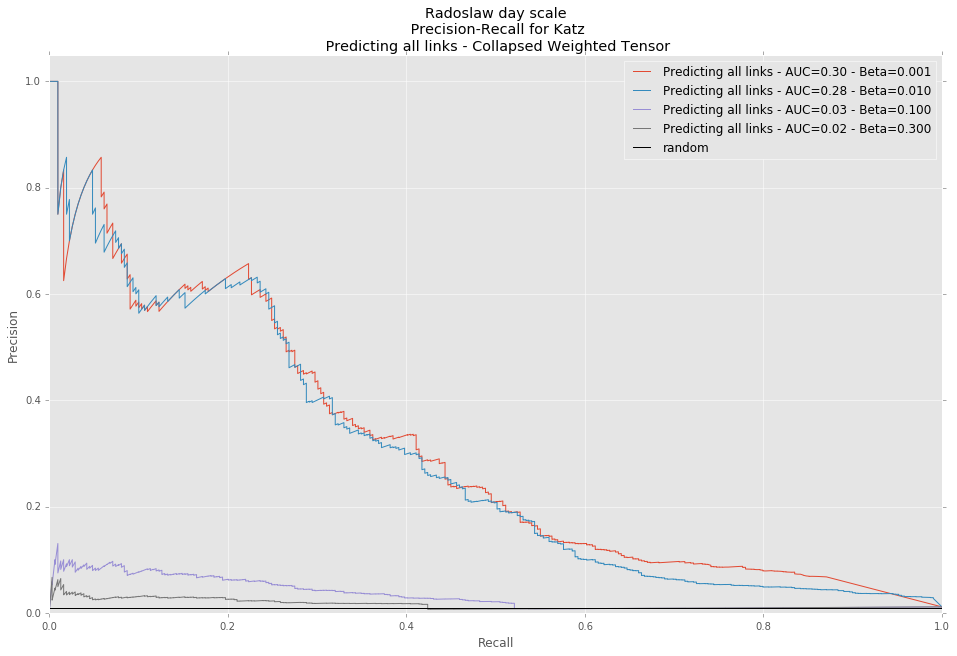

In [12]:
K_list = [1,5,10,30,50]
beta_list= [0.001]
#, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CWT.shape[0], CWT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

precision = dict()
recall = dict()
average_precision = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        S = np.linalg.inv(np.eye(CWT.shape[0]) - beta*CWT) - np.eye(CWT.shape[0])
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
        #precision[count], recall[count], _ = precision_recall_curve(y_test, y_score)
        #average_precision[count] = average_precision_score(y_test, y_score) 
        count += 1


# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale\n Precision-Recall for Katz\n Predicting all links - Collapsed Weighted Tensor')
plt.savefig('Radoslaw day Prec-Rec Predicting all links Katz_roc_cwt_%d.pdf' %(beta))  


### All in one

i=0
i=1
i=0
i=1


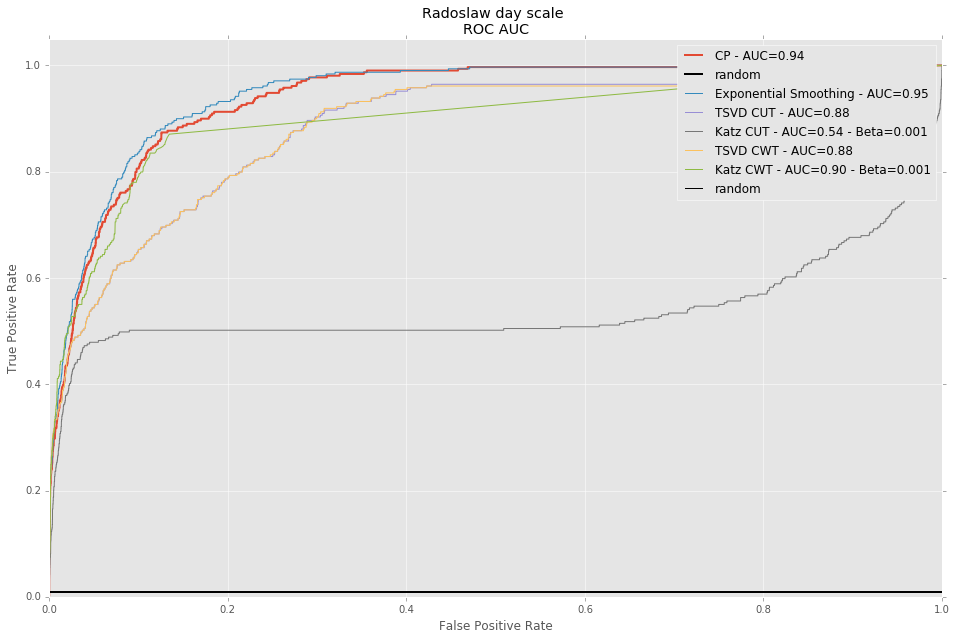

In [22]:
K_list = [1, 5, 10, 30, 50]
#tau_list = [7,15, 21]
tau_list = [7]
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

precision = dict()
recall = dict()
average_precision = dict()

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # CP Decomposition
        P, fit, itr, exectimes = cp_als(T_train, K, init='random')
        A, B, C = P.U
        # CP Scoring
        gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
        Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
        for i in range(Sk.shape[0]) :
            for j in range(Sk.shape[1]) :
                Sk[i,j] = float(Sk[i,j])
        S += Sk/LA.norm(Sk, 'fro')

    y_score = S.flatten()
    y_test = S_test.flatten()
    
    # Precision-Recall
    #precision[tau], recall[tau], _ = precision_recall_curve(y_test, y_score)
    #average_precision[tau] = average_precision_score(y_test, y_score)    
    # ROC 
    FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for tau_ind in range(len(tau_list)): 
    plt.plot(FPR[tau_ind], TPR[tau_ind], label='CP - AUC={0:0.2f}' .format(AUC[tau_ind]), linewidth = 2.0)

plt.axhline(mail_rate, label='random', color='black', linewidth=2.0)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.xlabel('False Positive Rate', fontsize=16)
#plt.ylabel('True Positive Rate', fontsize=16)
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.legend(loc="upper right", fontsize=14)
#plt.title('Radoslaw days scale \nROC for CP Factorization of rank K \nCollapsed Unweighted Tensor', fontsize=20)
#plt.savefig('Radoslaw days cp_roc_cut.pdf')    

K_list = [1, 5, 10, 30, 50, 100]
tau_list = [7]
#, 15, 21]
alpha_list = [0.2]
#, 0.5, 0.8]

for alpha_ind in range(len(alpha_list)):
    # Initialization
    FPR = dict()
    TPR = dict()
    AUC = dict()
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

        y_score = S.flatten()
        y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

        # ROC 
        FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)

    # Plotting the results
    #plt.clf()
    #plt.figure(figsize=(16, 10))

    for tau_ind in range(len(tau_list)): 
        plt.plot(FPR[tau_ind], TPR[tau_ind], label='Exponential Smoothing - AUC={0:0.2f}' .format(AUC[tau_ind]))

    #plt.axhline(mail_rate, label='random', color='black')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.legend(loc="upper right")
    #plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \
    #              \nCollapsed Weighted Tensor -  Alpha = %.2f - Exponential Smoothing' %(alpha))
    #plt.savefig('Radoslaw day cp_roc_cwt_%.2f Exponential Smoothing.pdf' %(alpha))   
    
    
S = np.zeros((CWT.shape[0], CWT.shape[1]))
S_pred = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test_all = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

K_list = [1,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        
        # Precision-Recall
        #precision, recall, _ = precision_recall_curve(y_test,y_score)
        #average_precision = average_precision_score(y_test, y_score)    

        # ROC 
        FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        plt.plot(FPR[i], TPR[i], label='TSVD CUT - AUC={0:0.2f}' .format(AUC[i]))
        #plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))
    #else :
    #    plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))

    
K_list = [1,5,10,30,50]
beta_list= [0.001]
#, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CUT.shape[0], CUT.shape[1]))

# Initialization
precision = dict()
recall = dict()
average_precision = dict()

count = 0

for i in range(2) :
    print('i=%d' %(i))
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        S = np.linalg.inv(np.eye(CUT.shape[0]) - beta*CUT) - np.eye(CUT.shape[0])
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        #precision[count], recall[count], _ = precision_recall_curve(y_test,y_score)
        #average_precision[count] = average_precision_score(y_test, y_score)
        
        count += 1

# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Katz CUT - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
    count += 1
    
    
S = np.zeros((CWT.shape[0], CWT.shape[1]))

theta = 0.2
K_list = [1,5,10,30,50]
FPR = dict()
TPR = dict()
AUC = dict()

precision = {}
recall = {}
average_precision = {}

S_test = (1*np.array(T_test[:, :, 0] >= 1))

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        # ROC 
        FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
        #precision[i], recall[i], _ = precision_recall_curve(y_test, y_score)
        #average_precision[i] = average_precision_score(y_test, y_score) 
       
    
# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        plt.plot(FPR[i], TPR[i], label='TSVD CWT - AUC={0:0.2f}' .format(AUC[i]))
        #plt.plot(recall[i], precision[i], label='AUC={0:0.2f}' .format(average_precision[i]))
    #else :
     #   plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))

K_list = [1,5,10,30,50]
beta_list= [0.001]
#, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CWT.shape[0], CWT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

precision = dict()
recall = dict()
average_precision = dict()

count = 0

for i in range(2) :
    print('i=%d' %(i))
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        S = np.linalg.inv(np.eye(CWT.shape[0]) - beta*CWT) - np.eye(CWT.shape[0])
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
        #precision[count], recall[count], _ = precision_recall_curve(y_test, y_score)
        #average_precision[count] = average_precision_score(y_test, y_score) 
        count += 1


# Plotting the results
#plt.clf()
#plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Katz CWT - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
    count += 1
    
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw day scale \nROC AUC')